In [12]:
import warnings
warnings.filterwarnings('ignore')
import torch , torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F0\
0FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

In [27]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(train_folders)

43

In [73]:
def load_image(img_path, resize = True):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    if resize:
        img = cv2.resize(img, (64,64) , interpolation = cv2.INTER_AREA)
    
    return img

def show_image(img_path):
    img = load_image(img_path)
    plt.imshow(img)
    plt.axis('off')
    
    
def show_sign_grid(image_paths):
    images = [load_image(img) for img in image_paths]
    images = torch.as_tensor(images)
    images.shape
    images = images.permute(0,3,1,2)
    grid_img = torchvision.utils.make_grid(images, nrow = 11)
    plt.figure(figsize = (24,12))
    grid_img.shape
    plt.imshow(grid_img.permute(1,2,0))
    plt.axis('off')

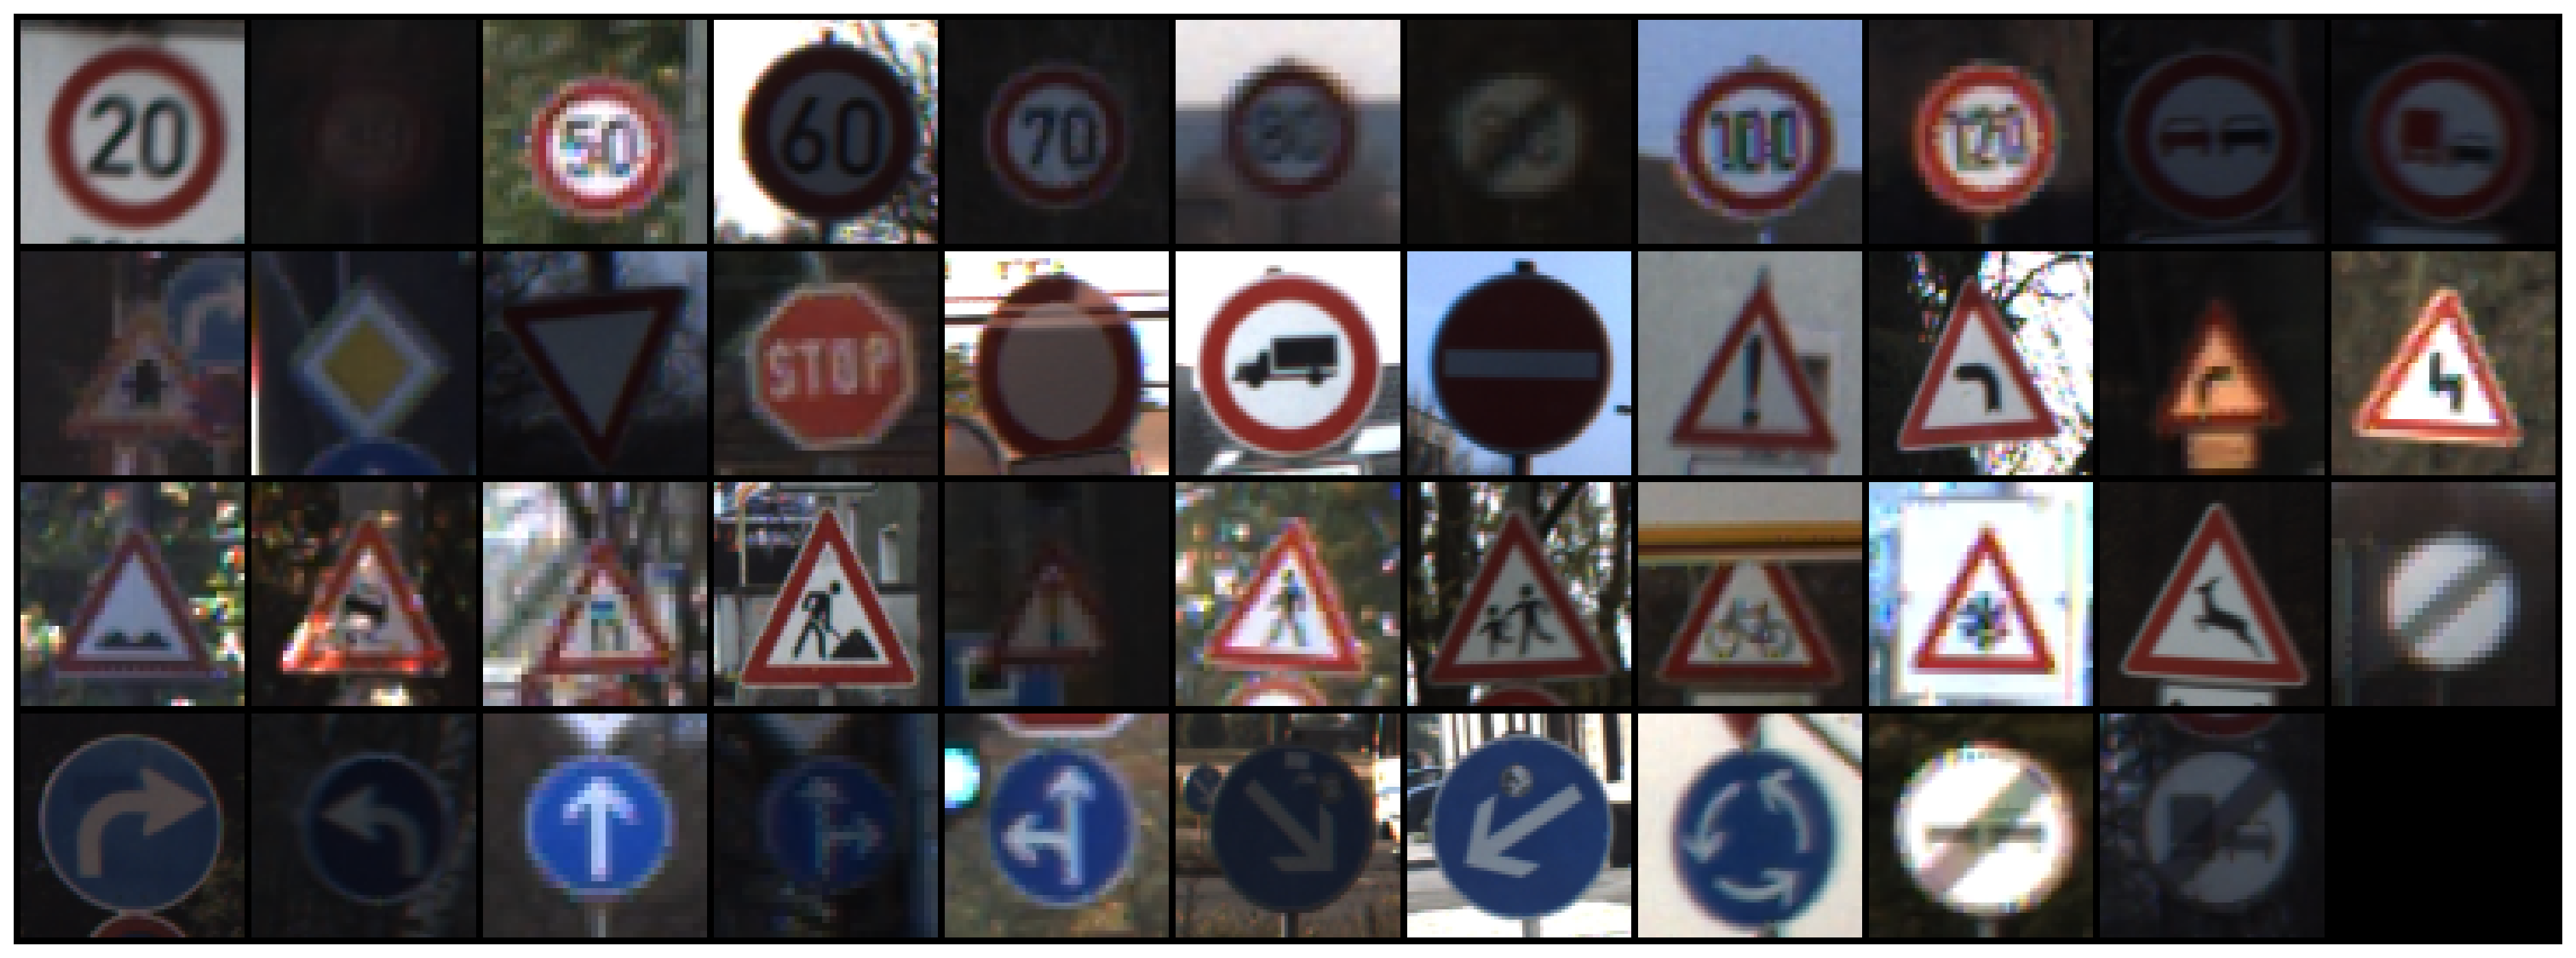

In [74]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
show_sign_grid(sample_images)

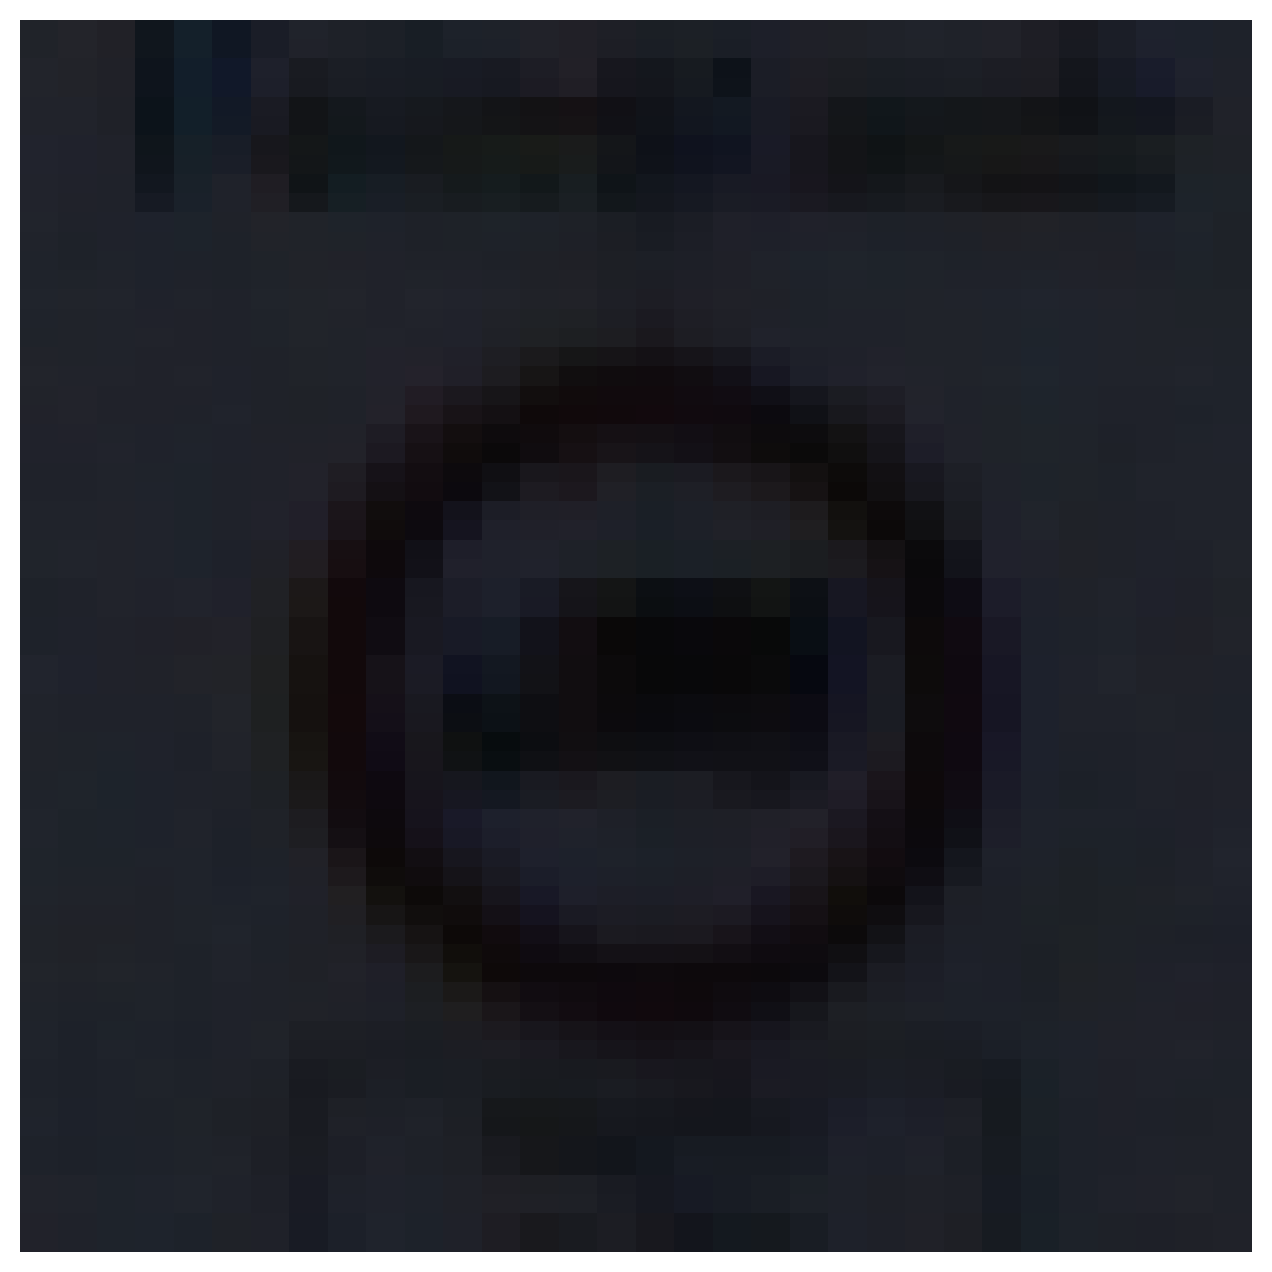

In [75]:
img_path = glob(f'{train_folders[16]}/*ppm')[1]
show_image(img_path)

In [55]:
class_names = ['priority_road', 'give_way', 'stop', 'no_entry']
class_indices = [12,13,14,17]

In [56]:
!rm -rf data

In [132]:
DATA_DIR = Path('data')
DATASETS = ['train', 'val', 'test']

In [58]:
for ds in DATASETS:
    for cls in class_names:
        (DATA_DIR/ds/cls).mkdir(parents=True, exist_ok = True)

In [61]:
for i, cls_index in enumerate(class_indices):
    image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
    class_name = class_names[i]
    print(f'{class_name}: {len(image_paths)}')
    np.random.shuffle(image_paths)
    
    ds_split = np.split(
        image_paths,
        indices_or_sections = [int(.8*len(image_paths)), int(.9*len(image_paths))]
    )
    dataset_data = zip(DATASETS, ds_split)
    for ds, images in dataset_data:
        for img_path in images:
            shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110


In [63]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.299, 0.224, 0.225]

transforms = {'train': T.Compose([
    T.RandomResizedCrop(size = 256),
    T.RandomRotation(degrees = 15),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean_nums,std_nums)
]), 'val': T.Compose([
    T.Resize(size = 256),
    T.CenterCrop(size = 224),
    T.ToTensor(),
    T.Normalize(mean_nums,std_nums)
]), 'test': T.Compose([
    T.Resize(size = 256),
    T.CenterCrop(size = 224),
    T.ToTensor(),
    T.Normalize(mean_nums,std_nums)
]),
}

In [65]:
image_datasets = {
    d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
    d: DataLoader(image_datasets[d], batch_size = 4, shuffle = True, num_workers = 4) for d in DATASETS
}

In [66]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 5926
     Root location: data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.299, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 1181
     Root location: data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.299, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 1188
     Root locati

In [68]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes
dataset_sizes

{'train': 5926, 'val': 1181, 'test': 1188}

In [71]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

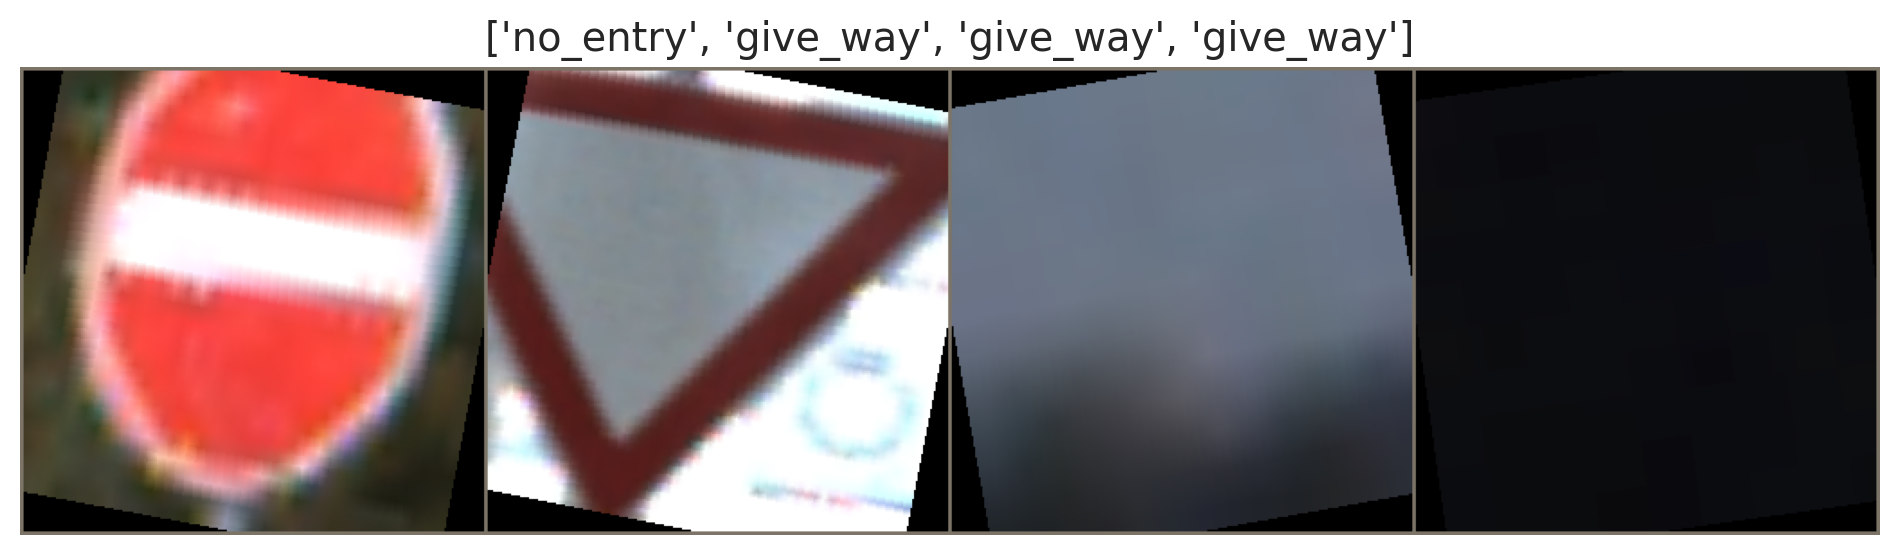

In [72]:
def imshow(inp, title = None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    plt.axis('off')
    
    
inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title = [class_names[x] for x in classes])

In [76]:
def create_model(n_classes):
    model = models.resnet34(pretrained = True)
    
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)
    
    return model.to(device)


In [77]:
base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/nitiz/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|████████████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:04<00:00, 21.6MB/s]


In [91]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim = 1)
        loss = loss_fn(outputs, labels)
        
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    scheduler.step()
    
    return correct_predictions.double()/ n_examples, np.mean(losses)

In [99]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for inputs , labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim = 1)
            loss = loss_fn(outputs, labels)
            
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
    return correct_predictions.double()/ n_examples, np.mean(losses)      

In [100]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):
    optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma= 0.1)
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    history = defaultdict(list)
    best_accuracy = 0
    
    
    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)
        train_acc, train_loss = train_epoch(
            model,
            data_loaders['train'],
            loss_fn,
            optimizer,
            device,
            scheduler,
            dataset_sizes['train']
        )
        
        print(f'Train loss {train_loss} accuracy {train_acc}')
        val_acc, val_loss = eval_model(
            model,
            data_loaders['val'],
            loss_fn,
            device,
            dataset_sizes['val']
        )
        
        print(f'Val loss {val_loss} accuracy {val_acc}')
        print()


        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc


        print(f'Best val accuracy: {best_accuracy}')

        model.load_state_dict(torch.load('best_model_state.bin'))
        
        return model, history
        

In [101]:
%%time
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/3
----------
Train loss 0.057841810691751 accuracy 0.9826189672629092
Val loss 0.000448069704964075 accuracy 1.0

Best val accuracy: 1.0
CPU times: user 52.5 s, sys: 1.27 s, total: 53.8 s
Wall time: 54.3 s


In [110]:
def show_predictions(model, class_names, n_images = 6):
    model = model.eval()
    images_handeled = 0
    plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.shape[0]):
                images_handeled += 1
                ax = plt.subplot(2, n_images//2, images_handeled)
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                ax.axis('off')

                if images_handeled == n_images:
                    return

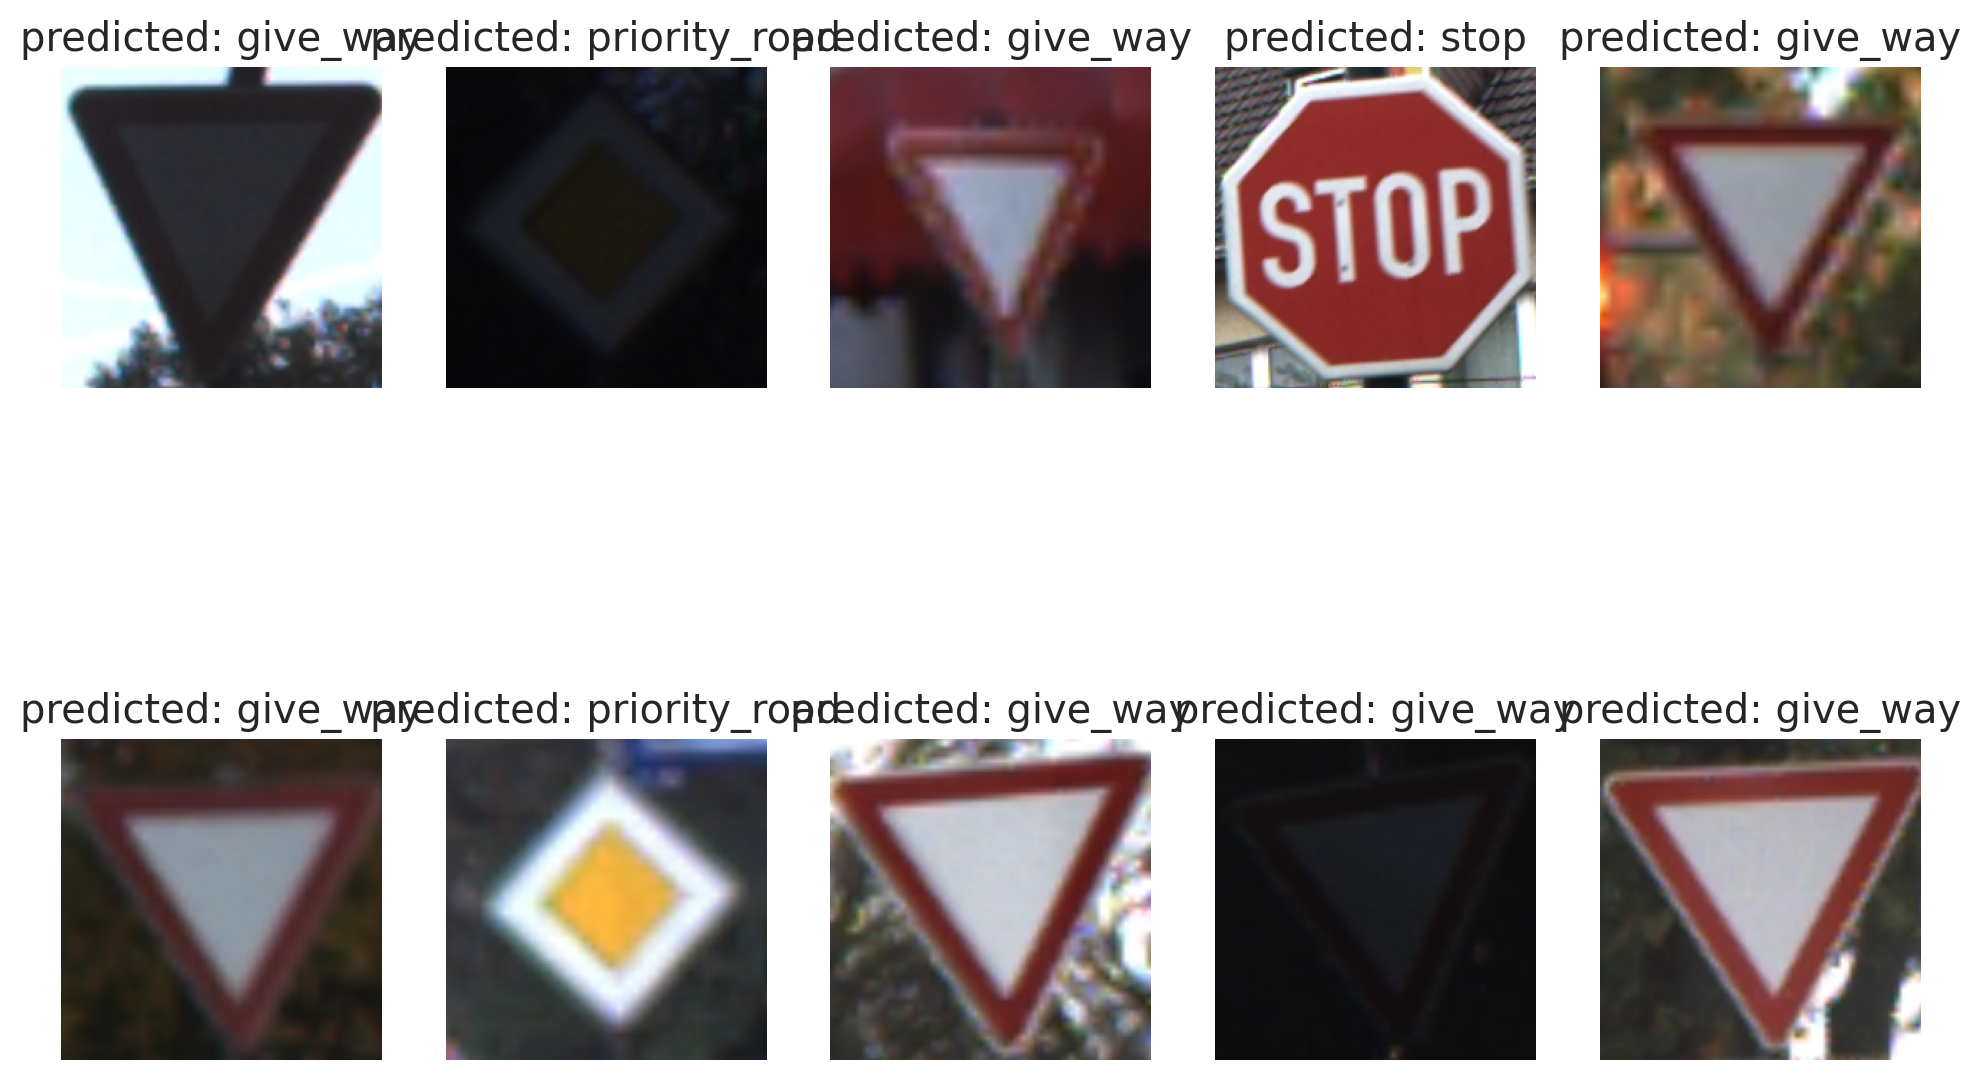

In [112]:
show_predictions(base_model, class_names, n_images=10)

In [114]:
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds)
            real_values.extend(labels)
    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()
    return predictions, real_values

In [115]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [116]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

     give_way       1.00      1.00      1.00       417
     no_entry       1.00      1.00      1.00       214
priority_road       1.00      1.00      1.00       406
         stop       1.00      1.00      1.00       151

     accuracy                           1.00      1188
    macro avg       1.00      1.00      1.00      1188
 weighted avg       1.00      1.00      1.00      1188



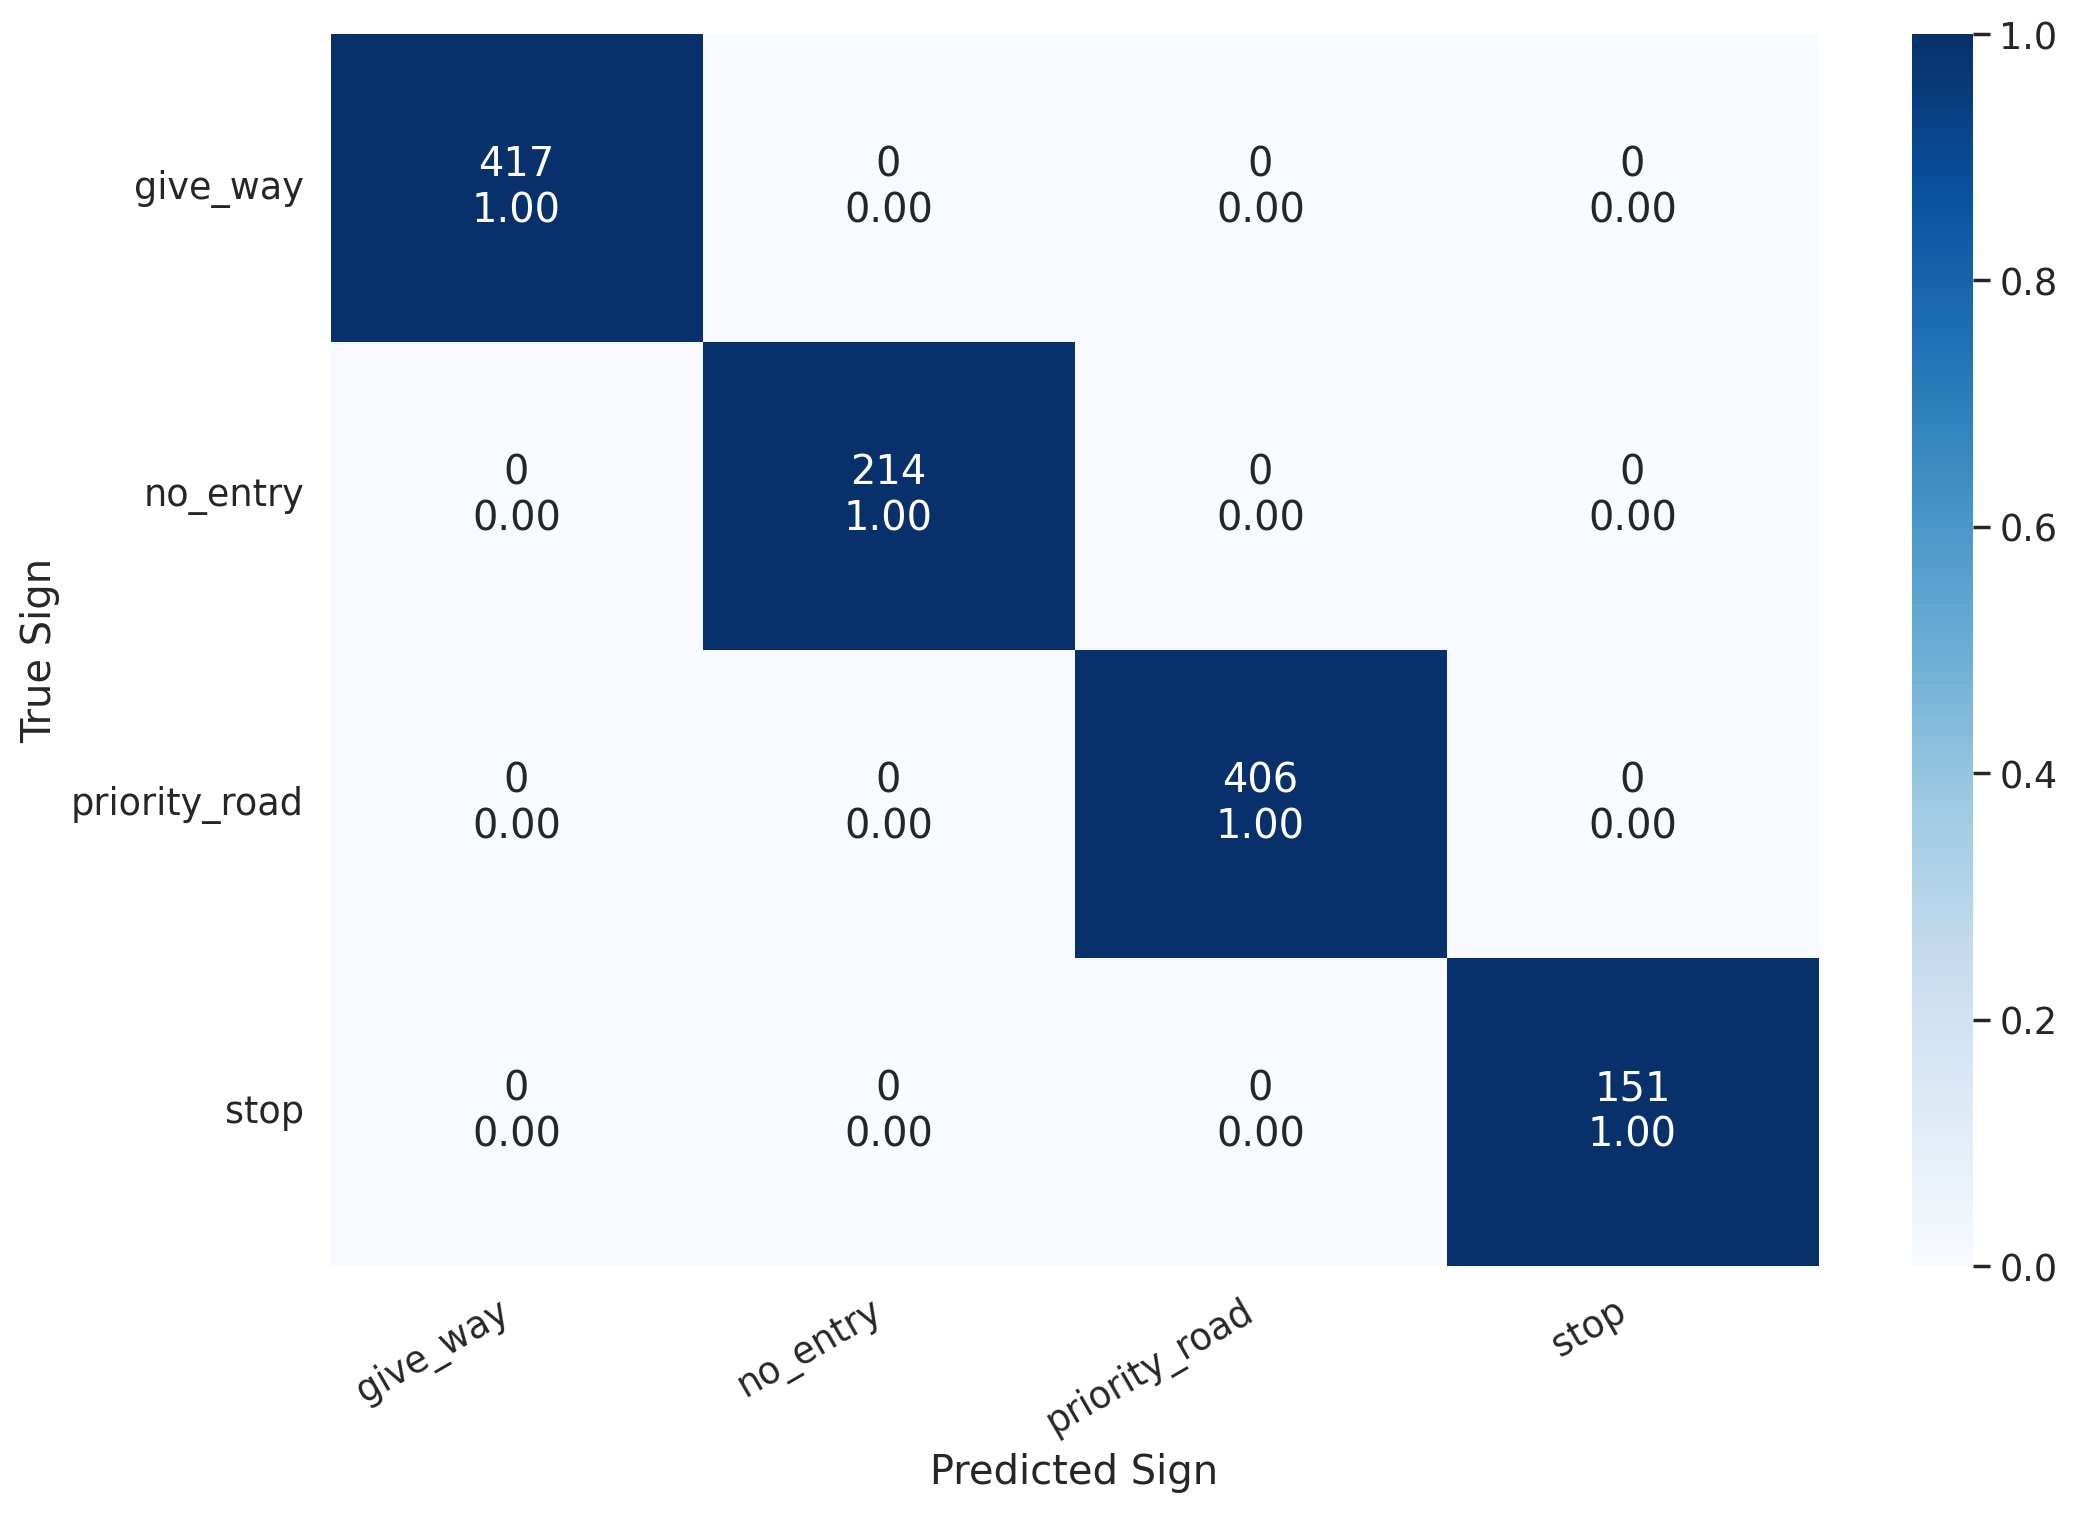

In [117]:
def show_confusion_matrix(confusion_matrix, class_names):
    cm = confusion_matrix.copy()
    cell_counts = cm.flatten()

    cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

    row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

    cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
    cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

    df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

    hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True Sign')
    plt.xlabel('Predicted Sign');
    
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

In [118]:
!gdown --id 19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr

/home/nitiz/anaconda3/envs/torch/lib/python3.11/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr
To: /home/nitiz/Desktop/notebooks/PyTorch/stop-sign.jpg
100%|██████████████████████████████████████| 77.3k/77.3k [00:00<00:00, 1.64MB/s]


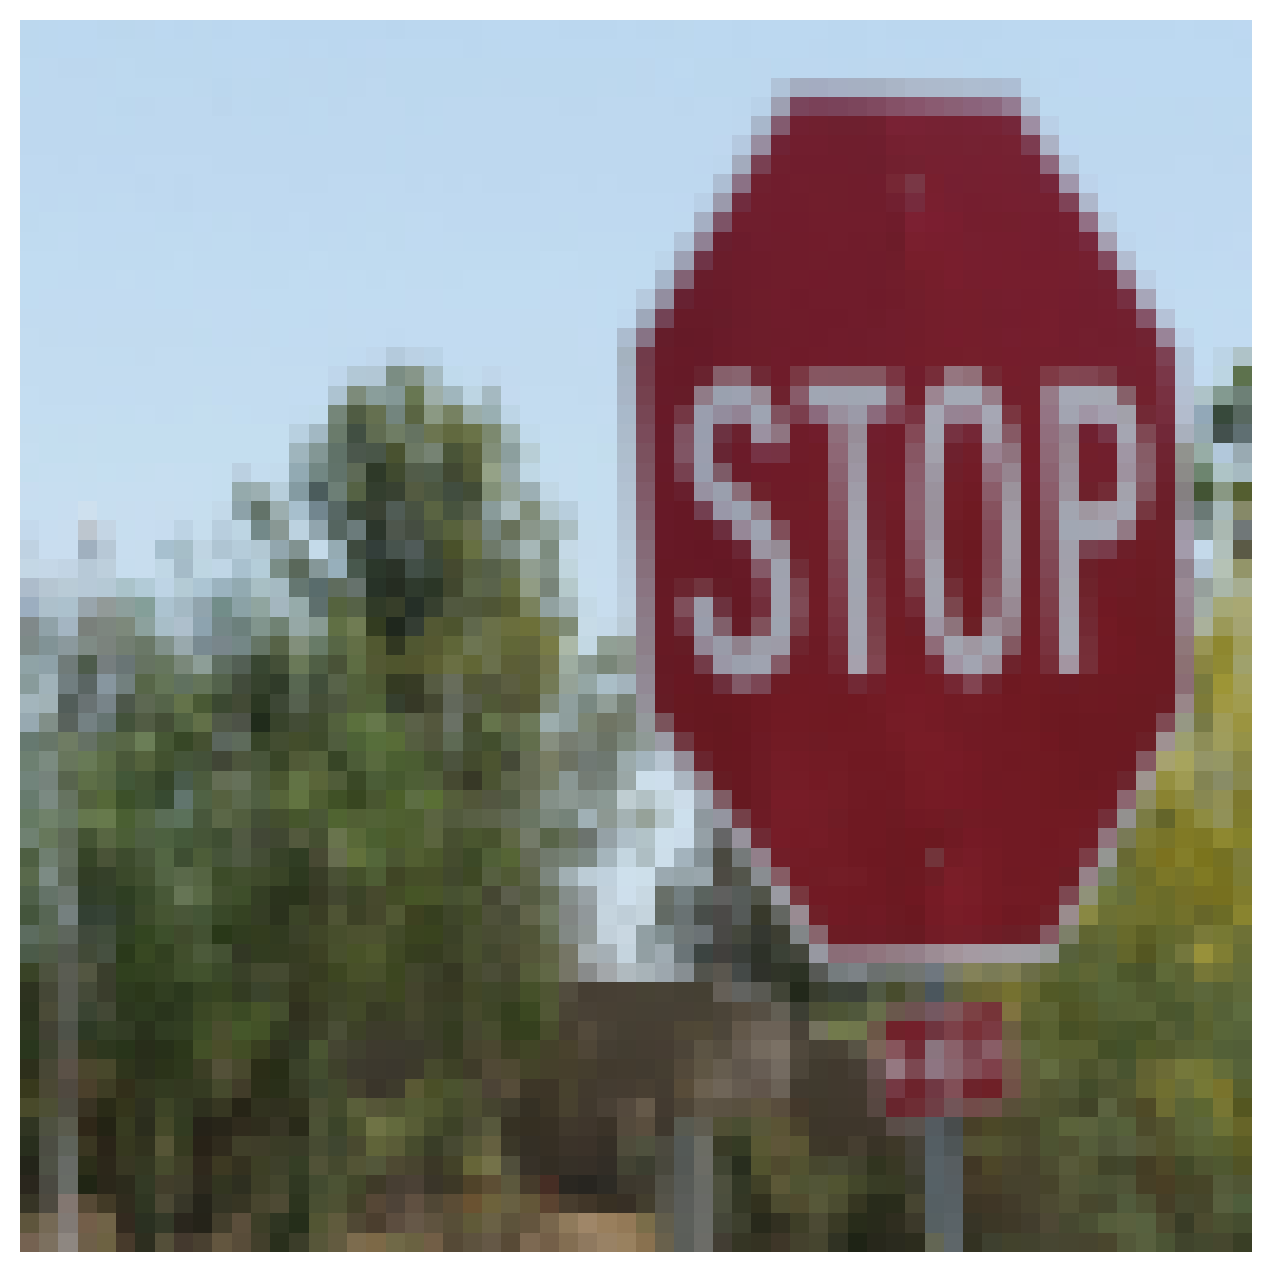

In [119]:
show_image('stop-sign.jpg')

In [120]:
def predict_proba(model, image_path):
    img = Image.open(image_path)
    img = img.convert('RGB')
    img = transforms['test'](img).unsqueeze(0)
    pred = model(img.to(device))
    pred = F.softmax(pred, dim=1)
    
    return pred.detach().cpu().numpy().flatten()

pred = predict_proba(base_model, 'stop-sign.jpg')
pred

array([0.00831649, 0.02433163, 0.02589488, 0.94145703], dtype=float32)

In [122]:
def show_prediction_confidence(prediction, class_names):
    pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
    })
    sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
    plt.xlim([0, 1]);

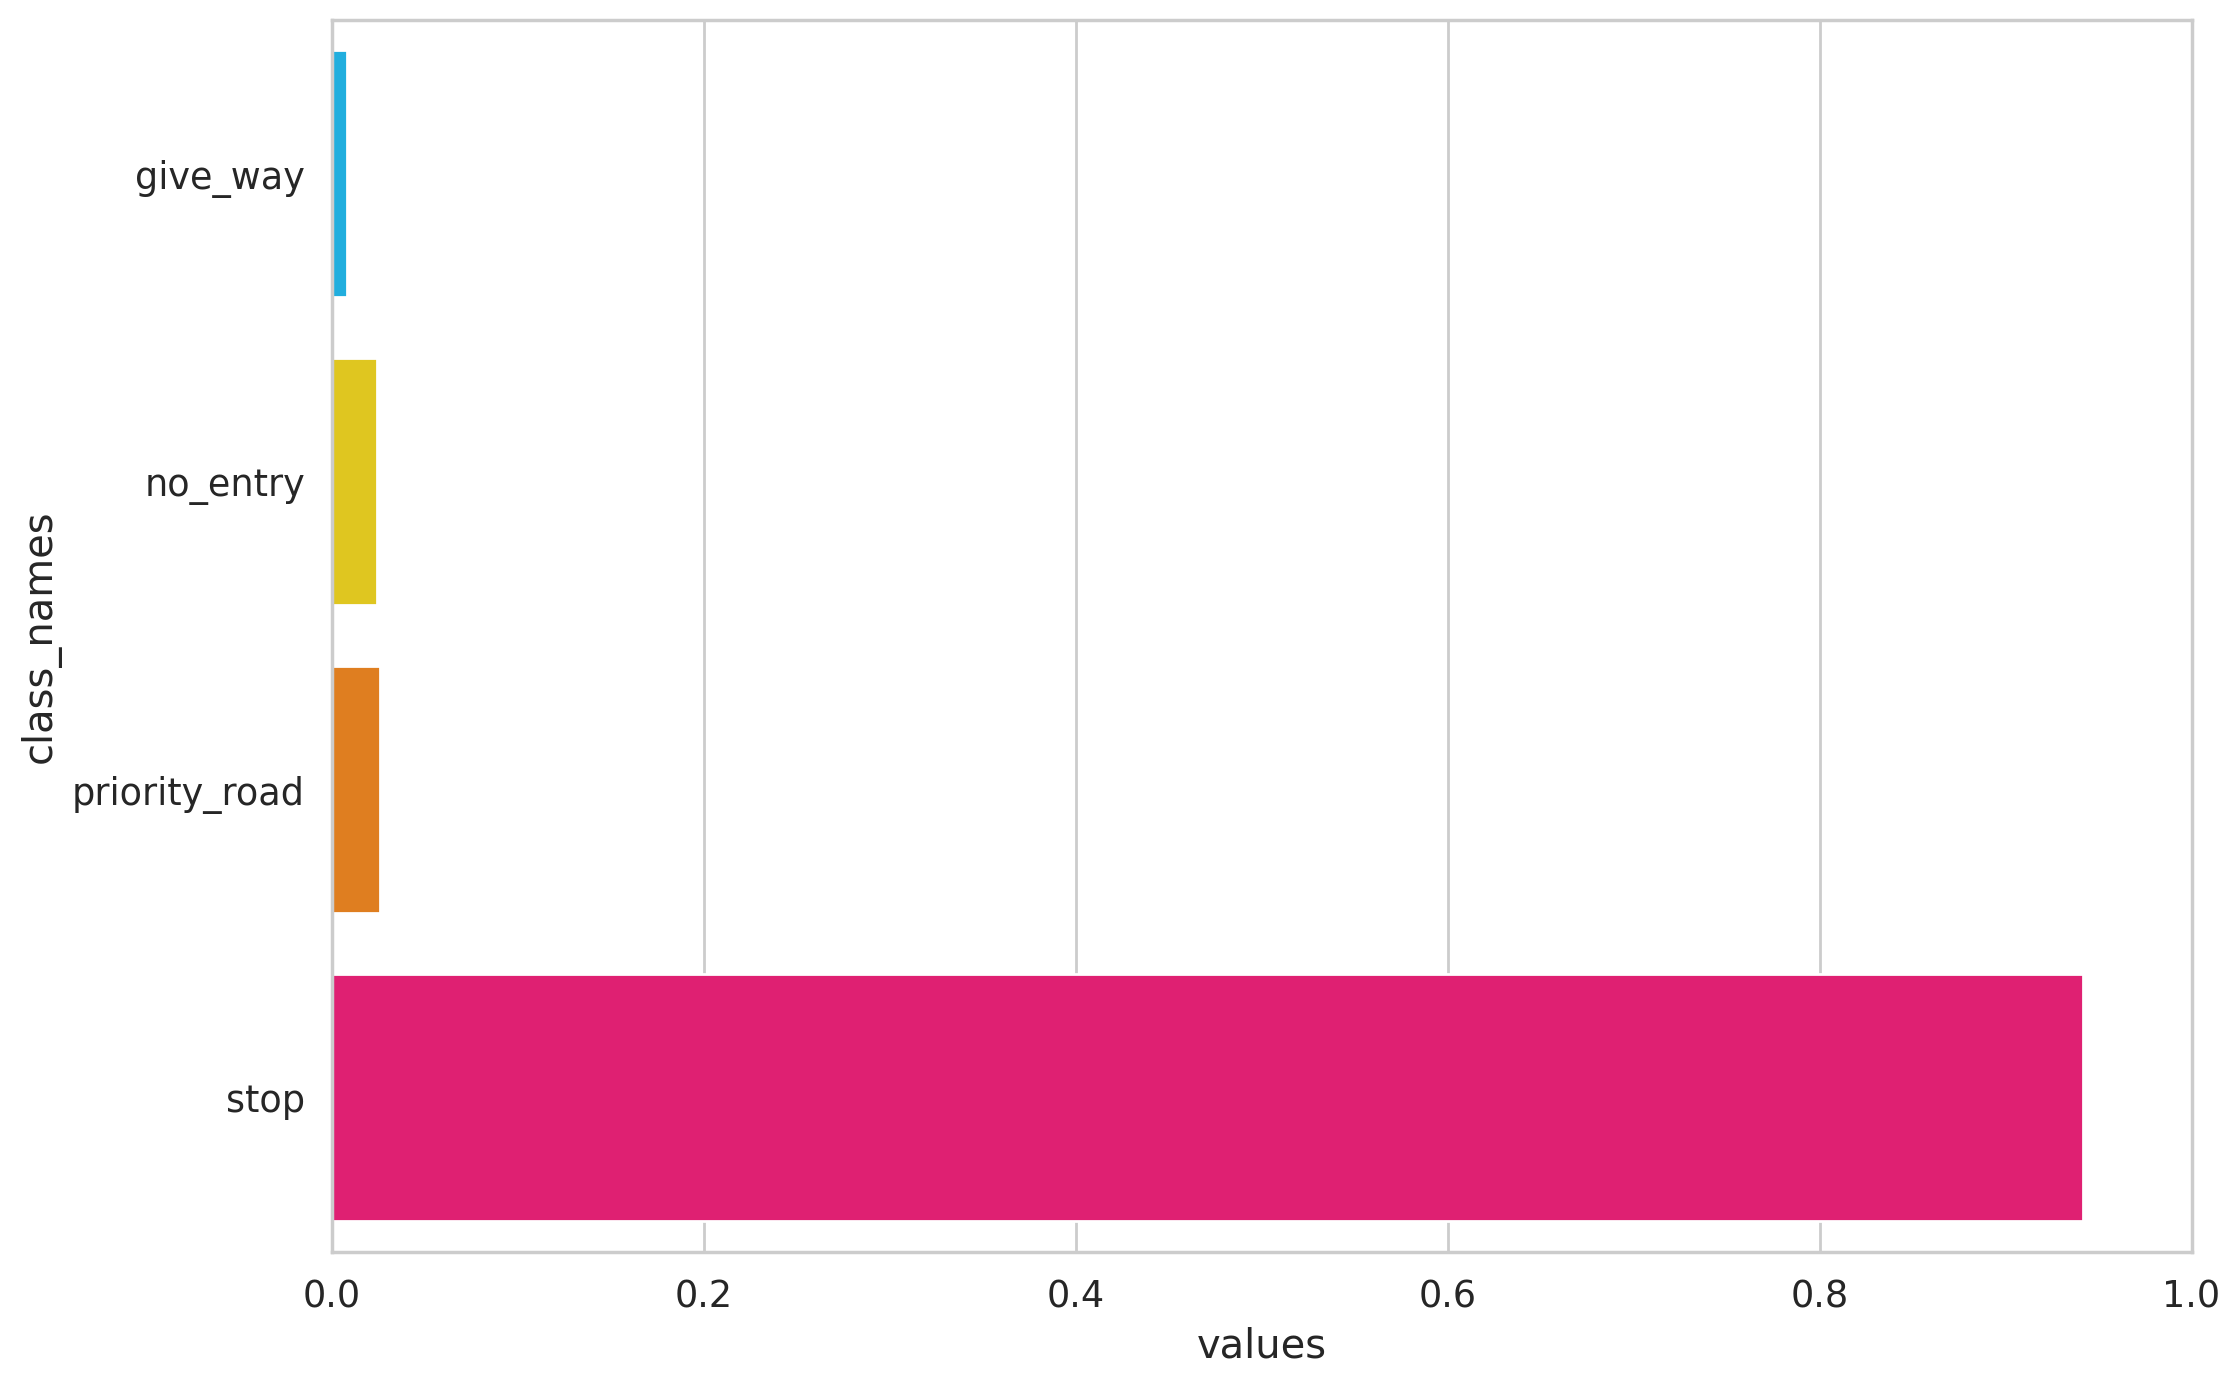

In [123]:
show_prediction_confidence(pred, class_names)

In [124]:
!gdown --id 1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u

/home/nitiz/anaconda3/envs/torch/lib/python3.11/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u
To: /home/nitiz/Desktop/notebooks/PyTorch/unknown-sign.jpg
100%|██████████████████████████████████████| 41.4k/41.4k [00:00<00:00, 1.27MB/s]


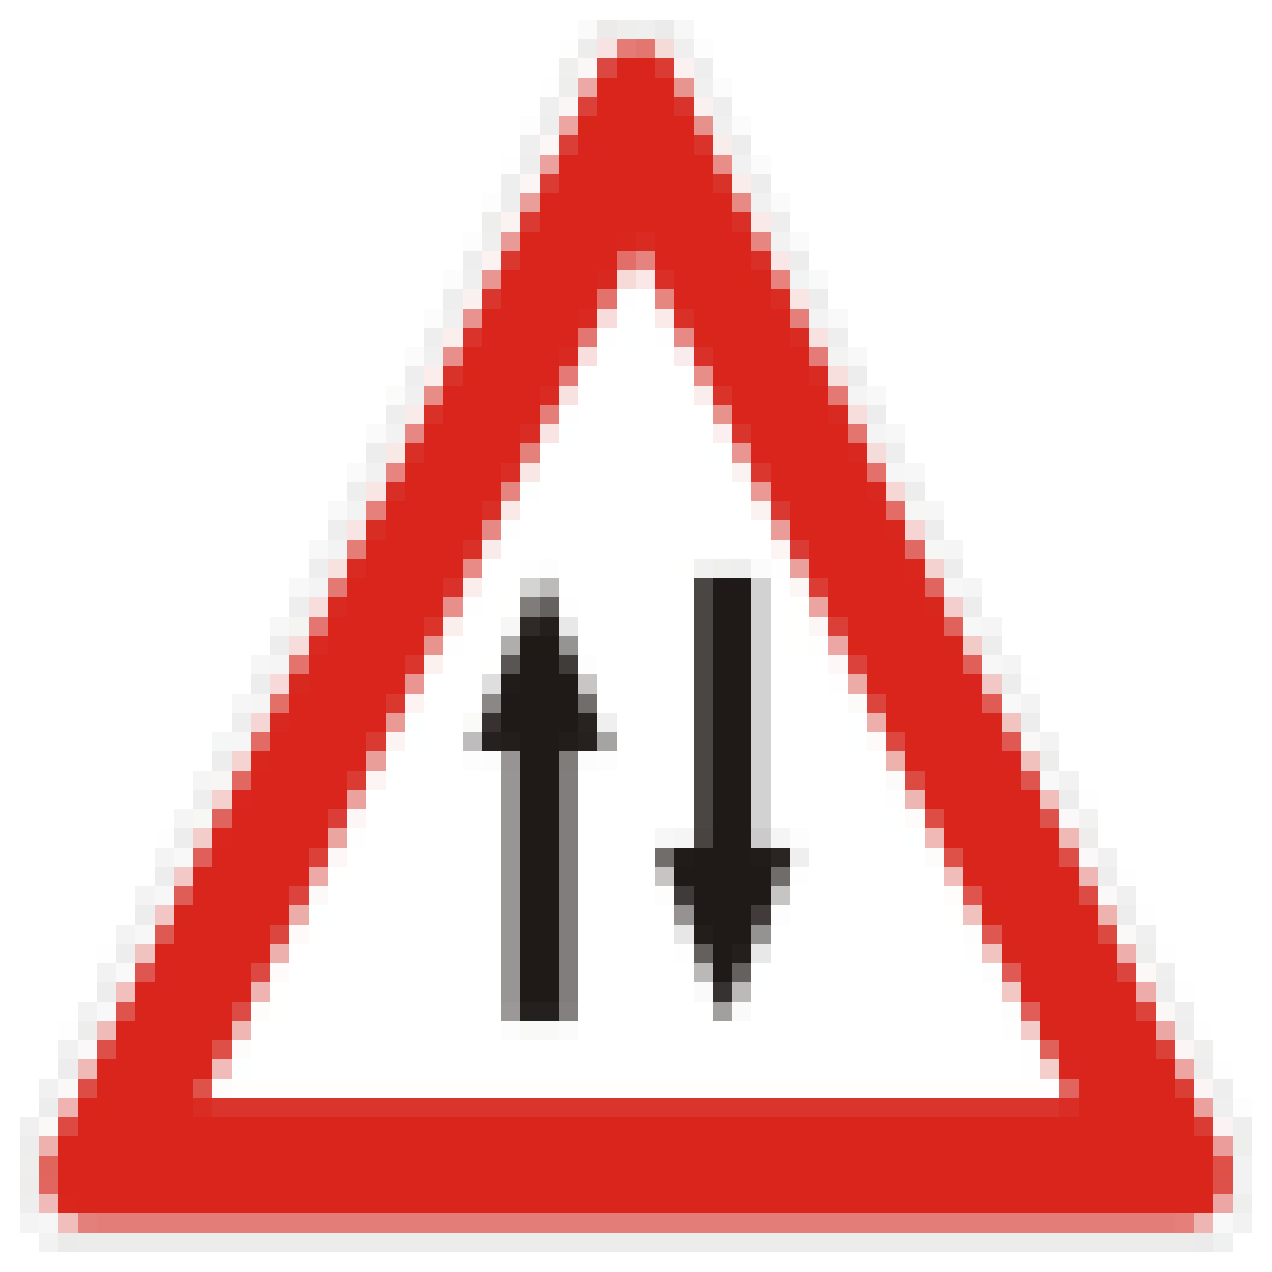

In [125]:
show_image('unknown-sign.jpg')

In [126]:
pred = predict_proba(base_model, 'unknown-sign.jpg')
pred

array([0.96950835, 0.00121993, 0.01992328, 0.00934846], dtype=float32)

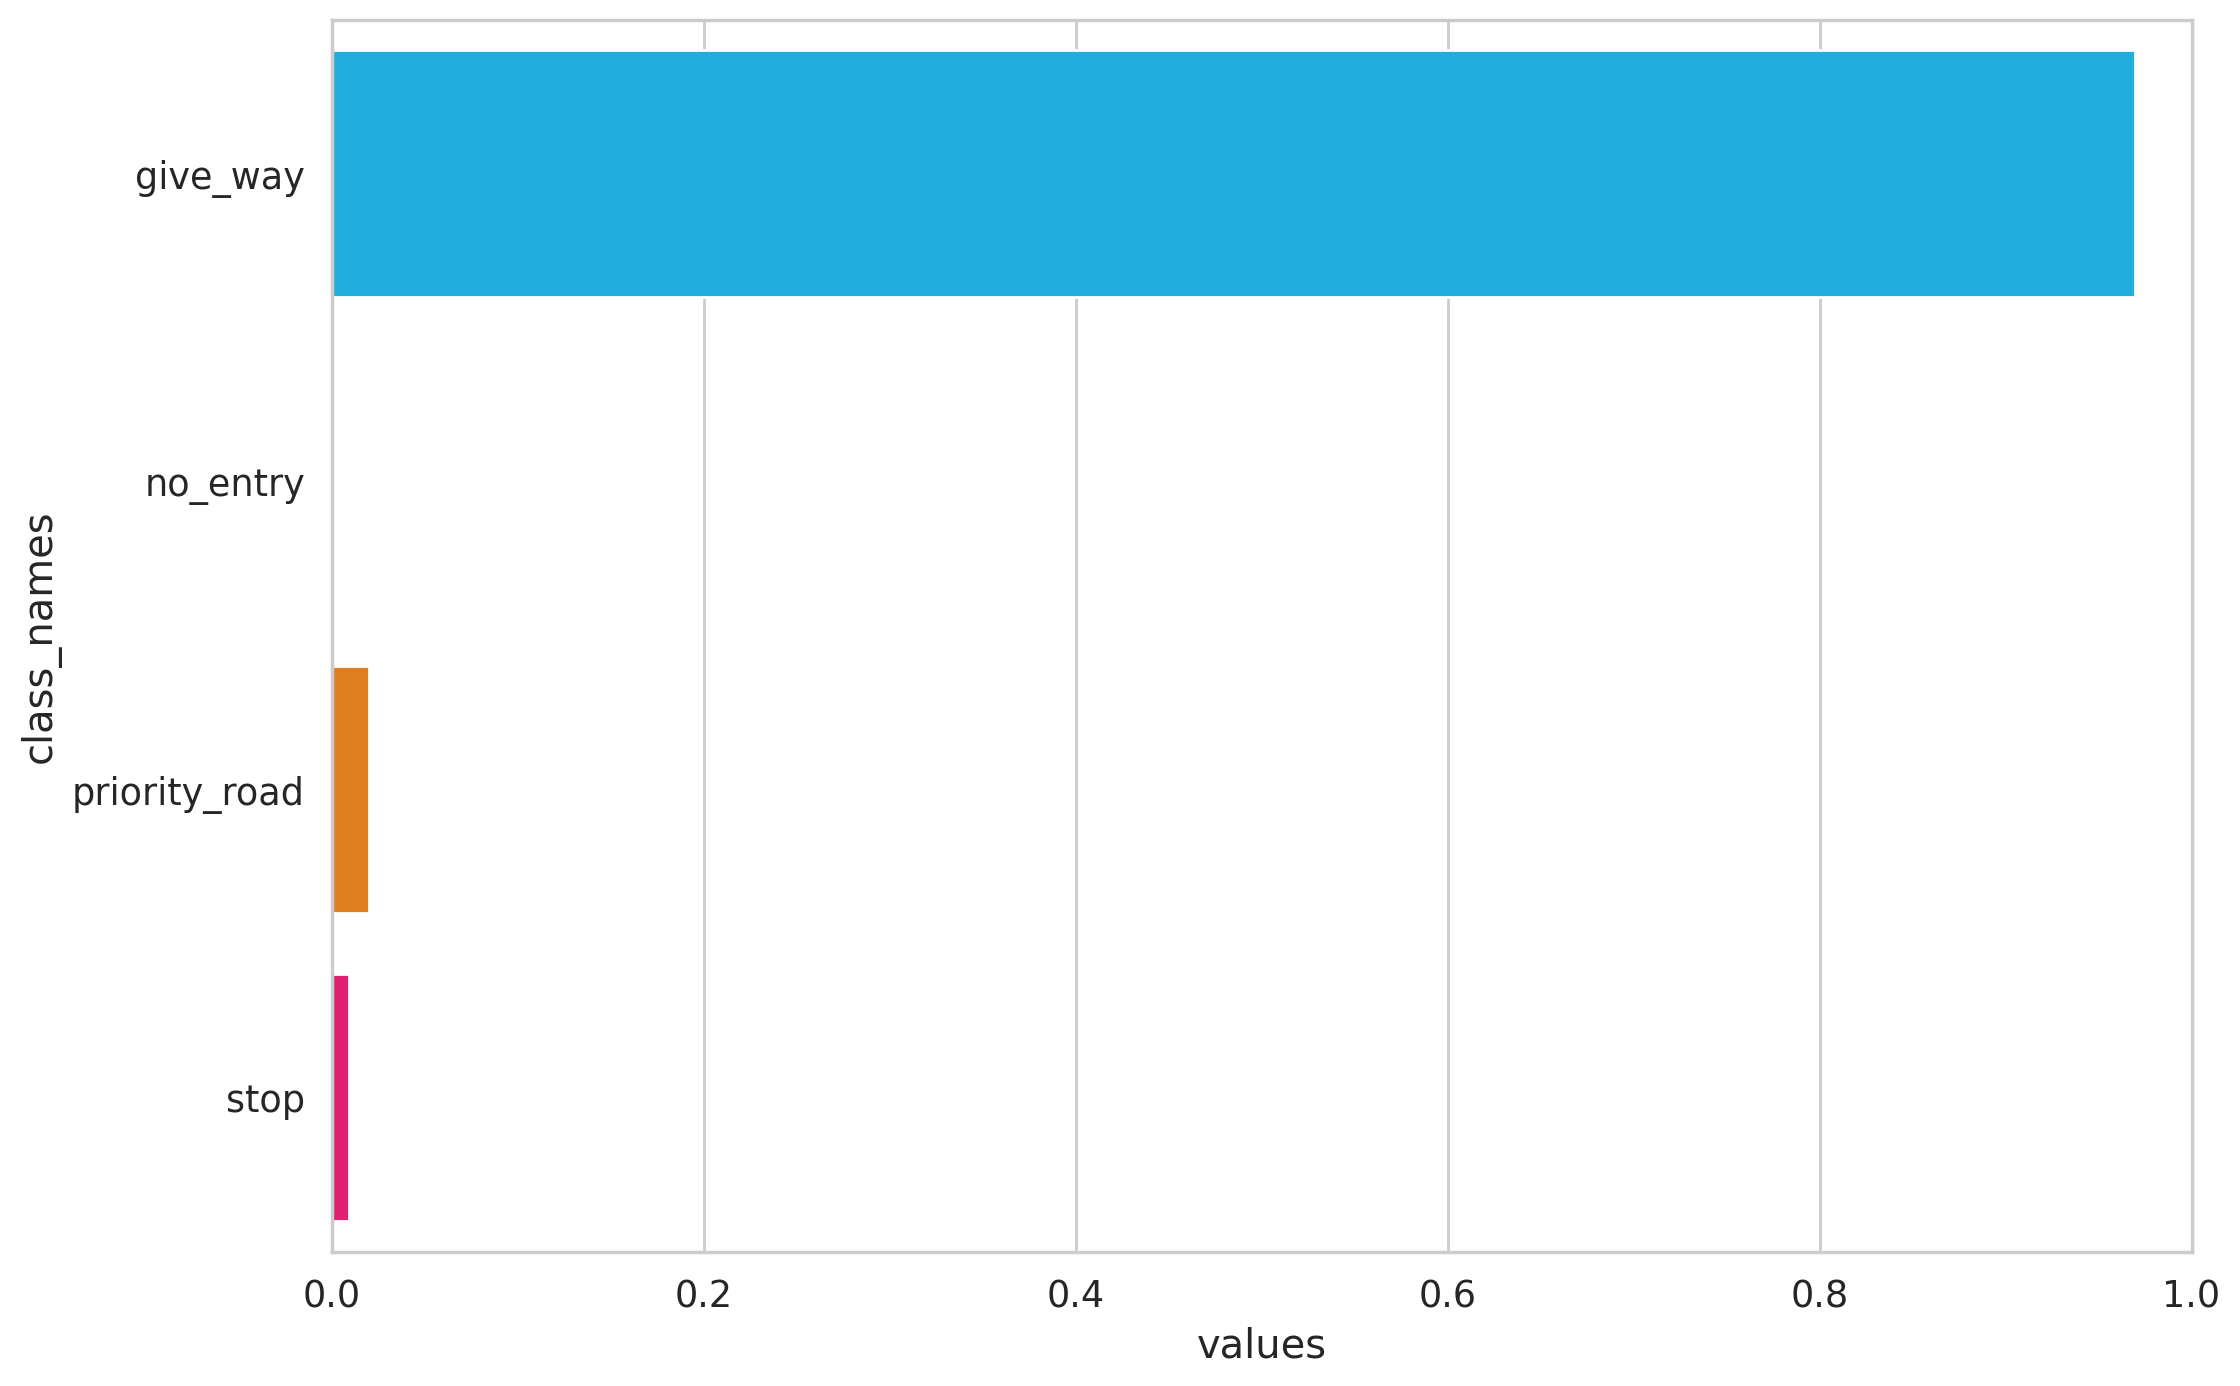

In [127]:
show_prediction_confidence(pred, class_names)

In [142]:
unknown_indices = [
i for i, f in enumerate(train_folders) \
if i not in class_indices
]
len(unknown_indices)

39

In [143]:

for ds in DATASETS:
    (DATA_DIR / ds / 'unknown').mkdir(parents=True, exist_ok=True)

for ui in unknown_indices:
    image_paths = np.array(glob(f'{train_folders[ui]}/*.ppm'))
    image_paths = np.random.choice(image_paths, 50)

    ds_split = np.split(
        image_paths, 
        indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
    )

    dataset_data = zip(DATASETS, ds_split)

    for ds, images in dataset_data:
        for img_path in images:
            shutil.copy(img_path, f'{DATA_DIR}/{ds}/unknown/')

In [144]:

image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 6684, 'val': 1359, 'test': 1362}

In [145]:

%%time

enchanced_model = create_model(len(class_names))
enchanced_model, history = train_model(enchanced_model, data_loaders, dataset_sizes, device)

Epoch 1/3
----------
Train loss 0.35887453873944286 accuracy 0.8834530221424297
Val loss 0.008345905858502246 accuracy 0.9963208241353937

Best val accuracy: 0.9963208241353937
CPU times: user 57.9 s, sys: 1.57 s, total: 59.5 s
Wall time: 59.9 s


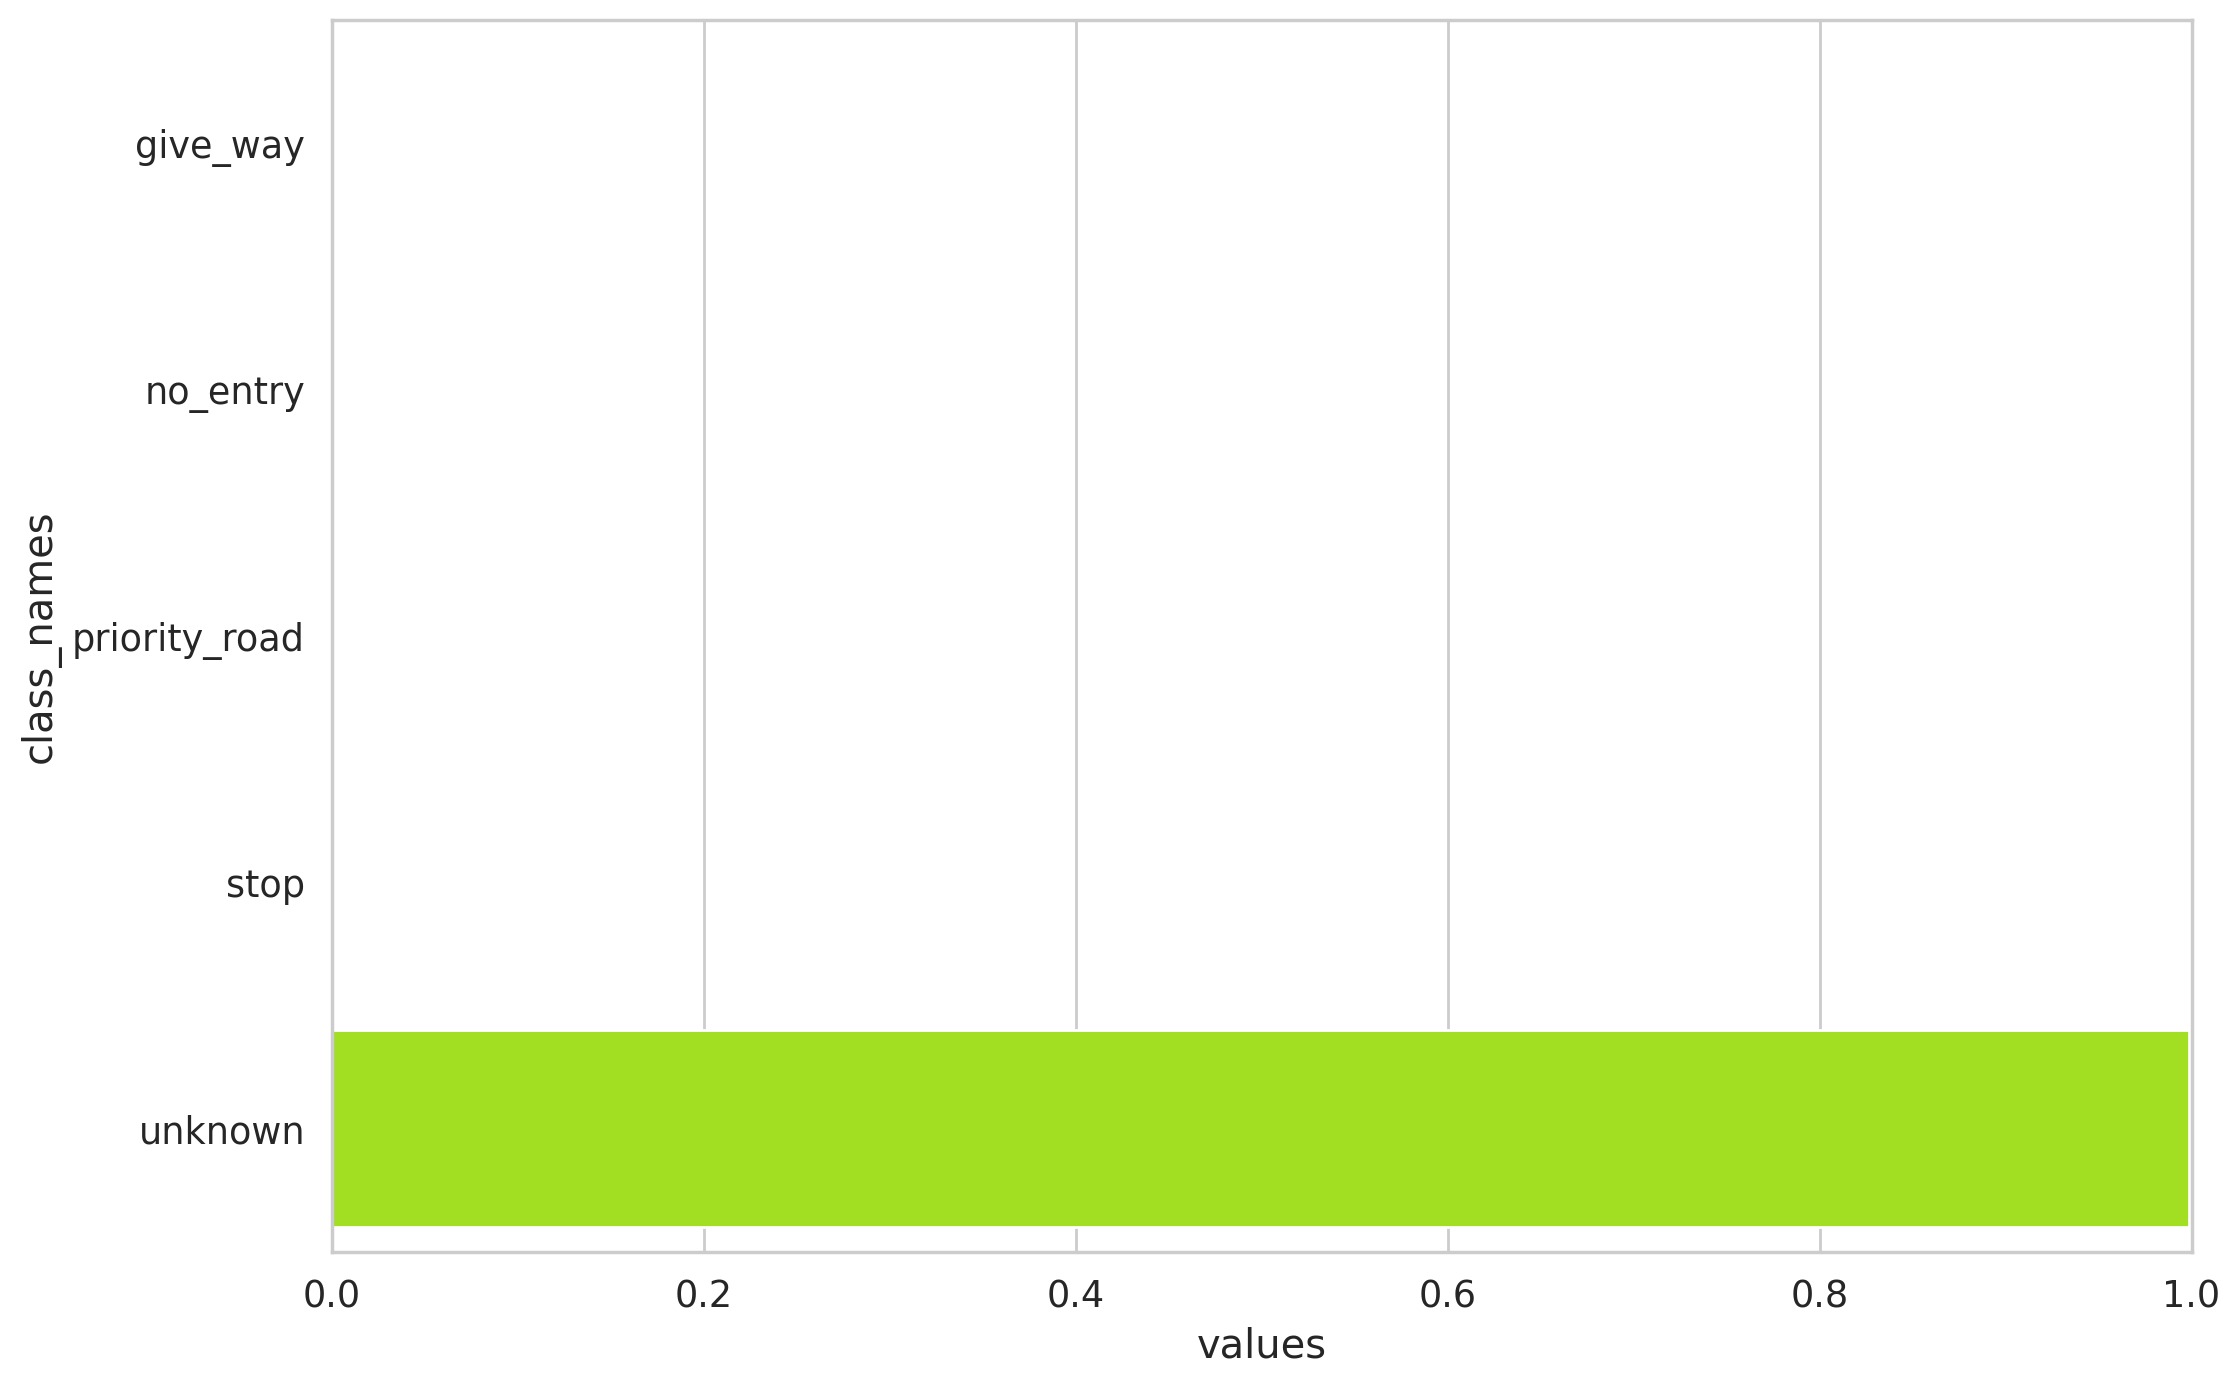

In [146]:
pred = predict_proba(enchanced_model, 'unknown-sign.jpg')
show_prediction_confidence(pred, class_names)

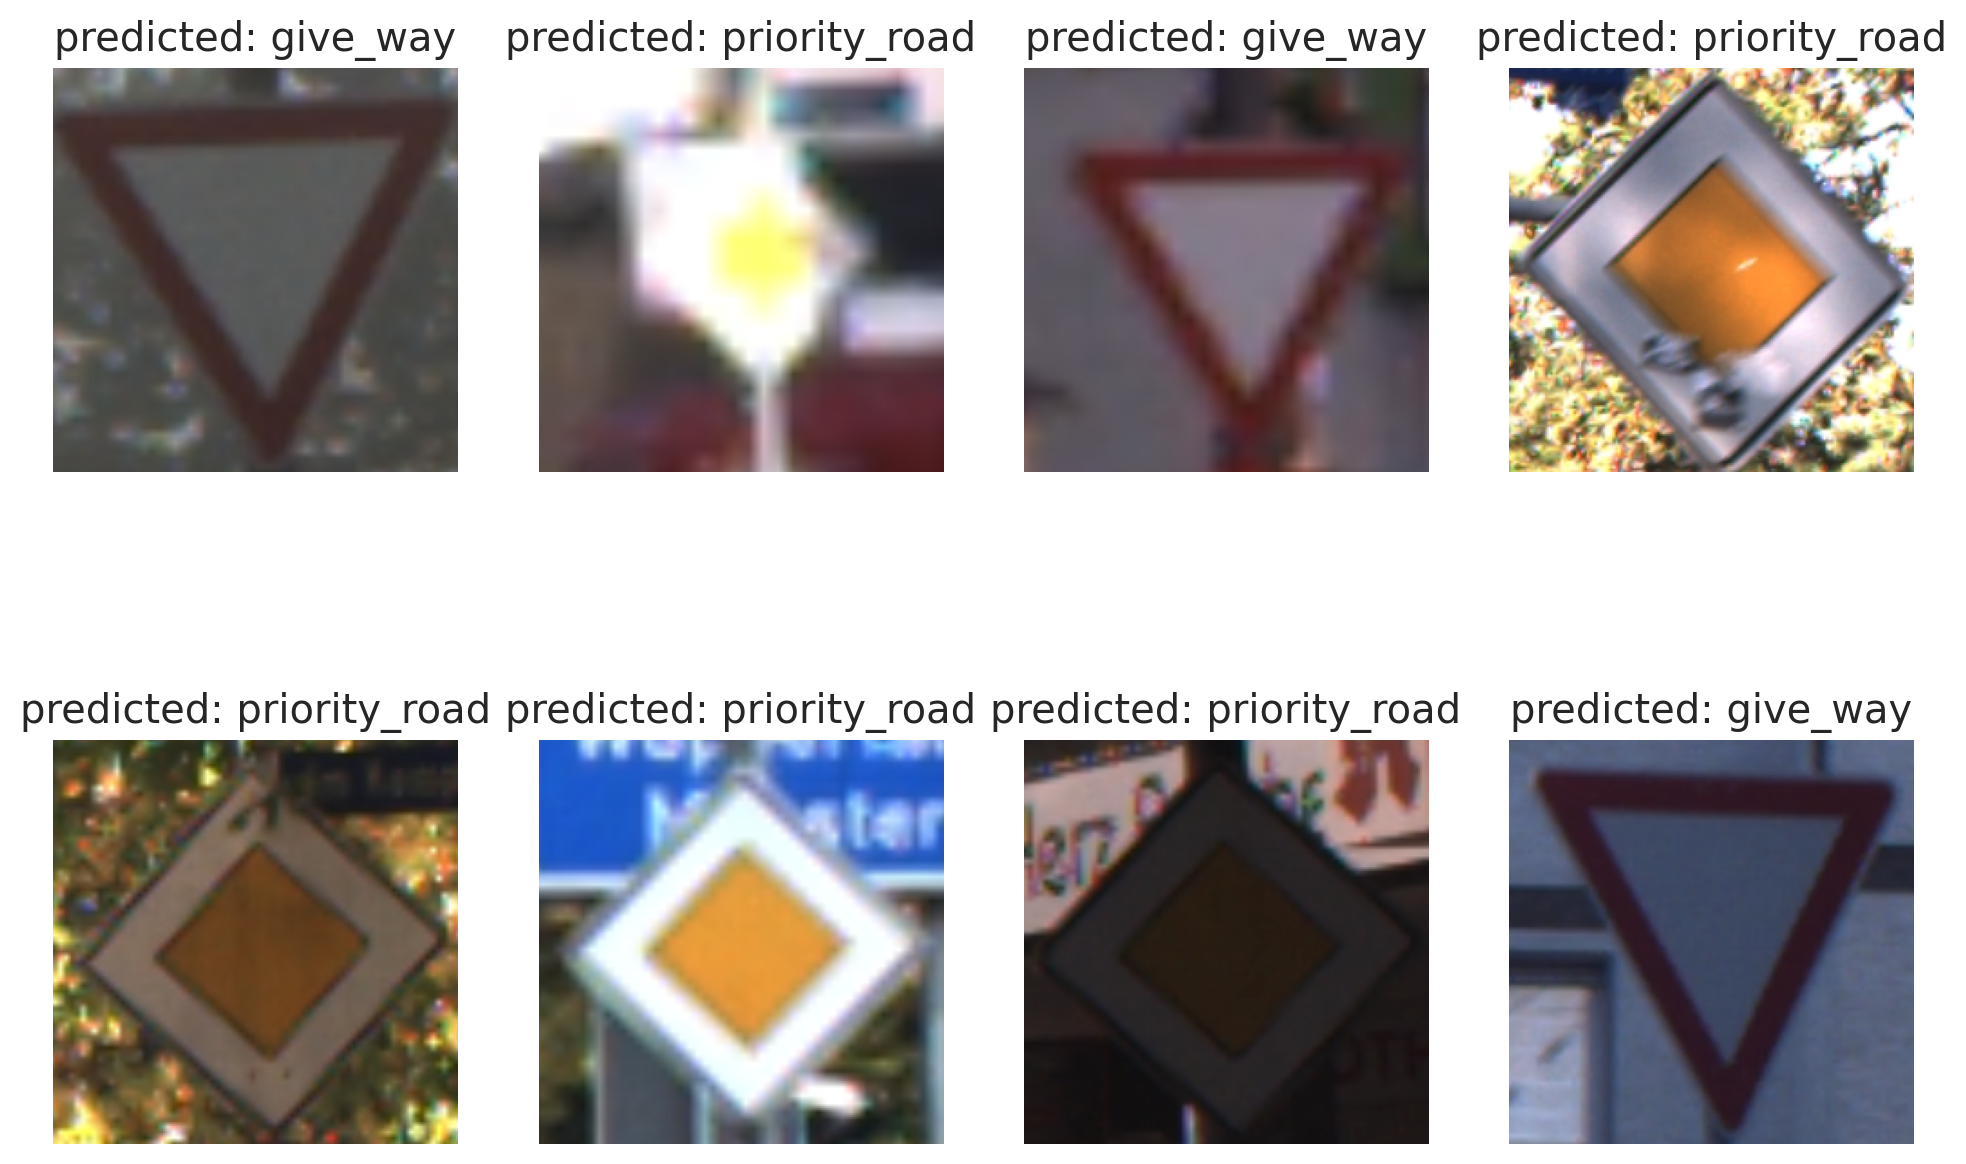

In [150]:
show_predictions(enchanced_model, class_names, n_images=8)


In [148]:
y_pred, y_test = get_predictions(enchanced_model, data_loaders['test'])
     

print(classification_report(y_test, y_pred, target_names=class_names))
     


               precision    recall  f1-score   support

     give_way       1.00      0.99      1.00       417
     no_entry       1.00      1.00      1.00       214
priority_road       0.99      1.00      0.99       406
         stop       1.00      1.00      1.00       151
      unknown       0.99      0.99      0.99       174

     accuracy                           1.00      1362
    macro avg       1.00      1.00      1.00      1362
 weighted avg       1.00      1.00      1.00      1362

